# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import yfinance as yf
from edge_risk_kit import *
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

### Loading tickers

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

response = requests.get(url)
html = response.content

snp = pd.read_html(html, header=0)[0]
snp = snp[['Symbol','Security','GICS Sector']].rename(columns={"Security":"Name","GICS Sector":"Industry"})
snp.set_index("Symbol", inplace=True)
snp.head()

,Name,Industry
Symbol,,
MMM,3M,Industrials
AOS,A. O. Smith,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture,Information Technology


### Loading ESG Scores

In [5]:
tickers = snp.index.to_list()
esg_data = pd.DataFrame([])

for ticker in tqdm(tickers):
    try:
        esg_scores = yf.Ticker(ticker).sustainability.T
        esg_scores['symbol'] = ticker
        esg_data = pd.concat([esg_data, esg_scores])
        
    except Exception as e:
        continue
        
esg_data.set_index('symbol', inplace=True)

  0%|          | 0/503 [00:00<?, ?it/s]

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GOOG?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=GOOG&crumb=rYpHnhFSaGI
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AMTM?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=AMTM&crumb=rYpHnhFSaGI
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BRK.B?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=BRK.B&crumb=rYpHnhFSaGI
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BF.B?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=BF.B&crumb=rYpHnhFSaGI
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FOX?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=FOX&crumb=rYpHnhFSaGI
404 Client Error: Not Found for url

In [6]:
required_cols = ['socialScore','governanceScore','environmentScore','totalEsg','peerGroup','highestControversy']
esg_data = esg_data[required_cols]
esg_data = esg_data.apply(pd.to_numeric, errors='ignore').sort_values(by=['totalEsg'], ascending=False)
esg_data.head()

,socialScore,governanceScore,environmentScore,totalEsg,peerGroup,highestControversy
symbol,,,,,,
XOM,11.58,6.99,25.09,43.66,Oil & Gas Producers,3.0
APA,8.26,7.12,27.69,43.08,Oil & Gas Producers,2.0
MMM,16.69,6.84,17.19,40.71,Industrial Conglomerates,5.0
TDG,18.25,8.06,11.89,38.20,Aerospace & Defense,2.0
OXY,9.06,6.44,22.33,37.83,Oil & Gas Producers,2.0


### Loading Prices

In [7]:
start_date = '2013-01-01'
end_date = '2023-12-31'

data = yf.download(tickers, start=start_date, end=end_date)
prices = data['Adj Close'][tickers]
prices = prices.dropna(axis=1, how='all')

prices = prices[prices.columns[prices.count() == prices.count().max()]]
prices.head()

[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['GEV', 'SW', 'AMTM', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Ticker,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WDC,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,54.016647,13.492394,25.492250,21.629183,55.729103,38.340000,2.53,7.568956,20.277971,27.099644,...,35.326256,18.593382,17.557236,73.639503,94.493149,18.666048,23.555803,38.550274,40.959999,59.709454
2013-01-03 00:00:00+00:00,53.953949,13.281476,26.462620,21.450583,55.527363,37.750000,2.49,7.527669,19.764177,27.196707,...,34.984703,18.593382,17.423098,74.391792,95.509521,18.611506,23.478708,38.791351,41.000000,60.564968
2013-01-04 00:00:00+00:00,54.352898,13.425573,26.303549,21.179598,55.834007,38.130001,2.59,7.706574,19.516657,27.733784,...,34.870842,18.746473,17.613989,74.370300,96.662010,18.679686,23.444447,39.216122,40.669998,60.873661
2013-01-07 00:00:00+00:00,54.421284,13.277303,26.518309,21.222706,55.591930,37.939999,2.67,7.465742,19.441647,27.533186,...,34.887115,18.803873,17.536591,74.155373,96.990105,18.481983,23.136084,38.969292,40.900002,61.023590
2013-01-08 00:00:00+00:00,54.426994,13.529986,26.526249,20.760809,55.914719,38.139999,2.67,7.465742,19.666670,27.313190,...,34.138947,18.931448,17.319902,73.789970,96.910080,18.516075,22.853411,37.333382,40.930000,61.111771


# Combining data to get full dataset

In [8]:
returns_monthly, cov_monthly = calcRetsCov(prices, 'M')
risk_data = summary_stats(returns_monthly, riskfree_rate=0.02, periods_per_year=12).sort_values('Sharpe Ratio', ascending=False)
risk_data.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
NVDA,0.604980,0.436502,0.005051,3.534284,0.157033,0.230212,1.315995,-0.628206
AVGO,0.408100,0.293364,0.263010,3.624960,0.098921,0.133827,1.299159,-0.316966
LRCX,0.445880,0.327460,0.087029,2.819608,0.117390,0.144741,1.277162,-0.450518
MSFT,0.294641,0.213010,0.176437,3.271839,0.073731,0.096285,1.266169,-0.305285
CTAS,0.322088,0.235414,-0.906693,9.975638,0.092304,0.127175,1.260118,-0.379073


In [9]:
full_data = risk_data.join(esg_data)
full_data = full_data[~full_data.totalEsg.isnull()]

full_data['esg_soc_grp'] = pd.cut(full_data.socialScore, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])
full_data['esg_env_grp'] = pd.cut(full_data.environmentScore, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])
full_data['esg_gov_grp'] = pd.cut(full_data.governanceScore, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])
full_data['esg_tot_grp'] = pd.cut(full_data.totalEsg, 5, labels=["Severe Risk", "High Risk", "Medium Risk", "Low Risk", "No Risk"])

full_data.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown,socialScore,governanceScore,environmentScore,totalEsg,peerGroup,highestControversy,esg_soc_grp,esg_env_grp,esg_gov_grp,esg_tot_grp
Ticker,,,,,,,,,,,,,,,,,,
NVDA,0.604980,0.436502,0.005051,3.534284,0.157033,0.230212,1.315995,-0.628206,4.45,6.00,2.45,12.90,Semiconductors,2.0,Severe Risk,Severe Risk,High Risk,Severe Risk
AVGO,0.408100,0.293364,0.263010,3.624960,0.098921,0.133827,1.299159,-0.316966,6.86,4.21,8.12,19.20,Semiconductors,2.0,High Risk,High Risk,Severe Risk,High Risk
LRCX,0.445880,0.327460,0.087029,2.819608,0.117390,0.144741,1.277162,-0.450518,4.18,3.76,4.28,12.21,Semiconductors,1.0,Severe Risk,Severe Risk,Severe Risk,Severe Risk
MSFT,0.294641,0.213010,0.176437,3.271839,0.073731,0.096285,1.266169,-0.305285,7.62,4.96,1.65,14.23,Software & Services,3.0,High Risk,Severe Risk,Severe Risk,High Risk
CTAS,0.322088,0.235414,-0.906693,9.975638,0.092304,0.127175,1.260118,-0.379073,8.24,5.61,3.19,17.03,Commercial Services,2.0,High Risk,Severe Risk,High Risk,High Risk


In [33]:
full_data.to_csv('Full_data_ESG.csv')
full_data = pd.read_csv('Full_data_ESG.csv')
full_data.set_index('Ticker', inplace=True)

# Analytics

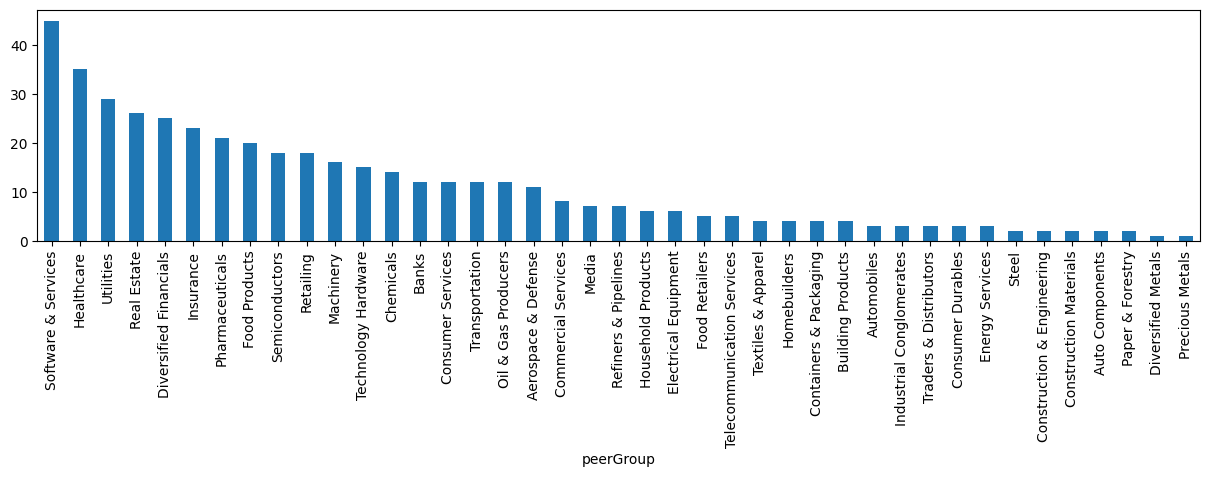

5 sectors with most securities: Software & Services, Healthcare, Utilities, Real Estate, Diversified Financials


In [38]:
full_data.peerGroup.value_counts().plot.bar(figsize=(15,3))
plt.show()

print('5 sectors with most securities: {}'.format(', '.join(full_data.peerGroup.value_counts().head().index.to_list())))

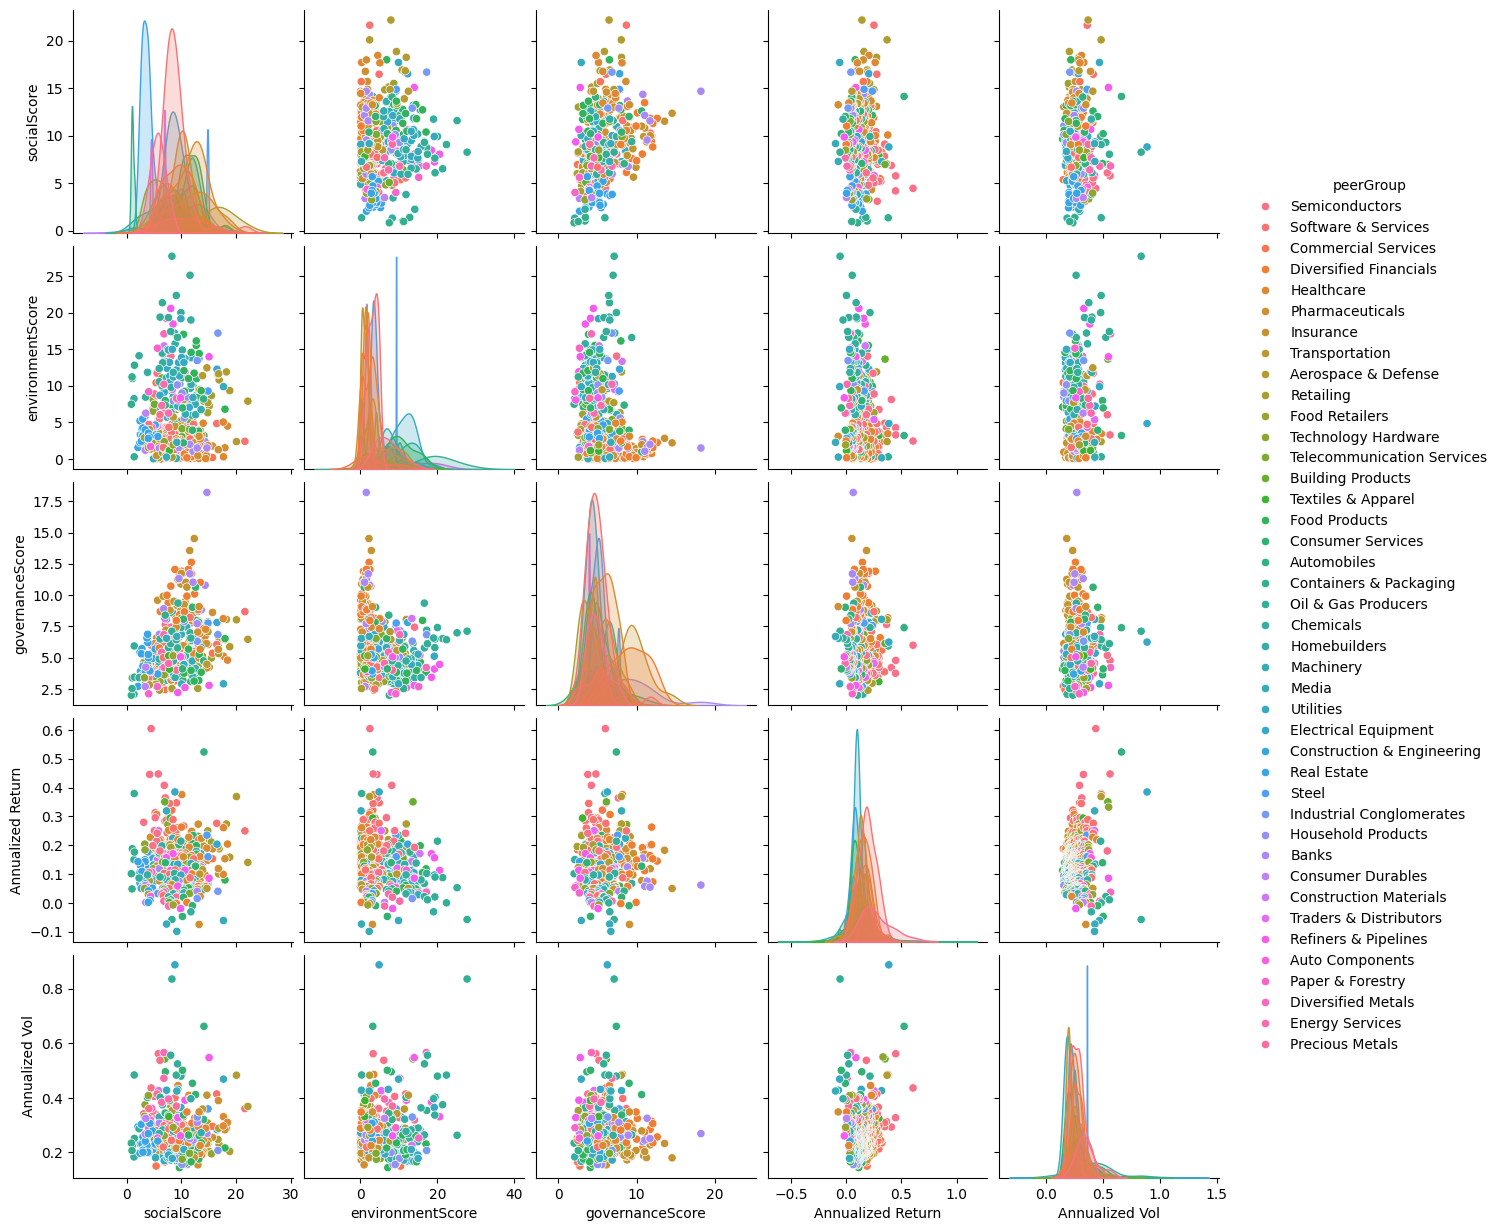

In [35]:
sns.pairplot(data = full_data[['socialScore','environmentScore','governanceScore','Annualized Return','Annualized Vol','peerGroup']], hue='peerGroup')
plt.show()

# Portfolio Analysis

### Stock Selection 1
<br>Sector = All
<br>Number of portfolios = 4
<br>Stock selection = Top 25 securities in each of social, governance, environment, total ESG ScorePortfolio Names:Portfolio Names:


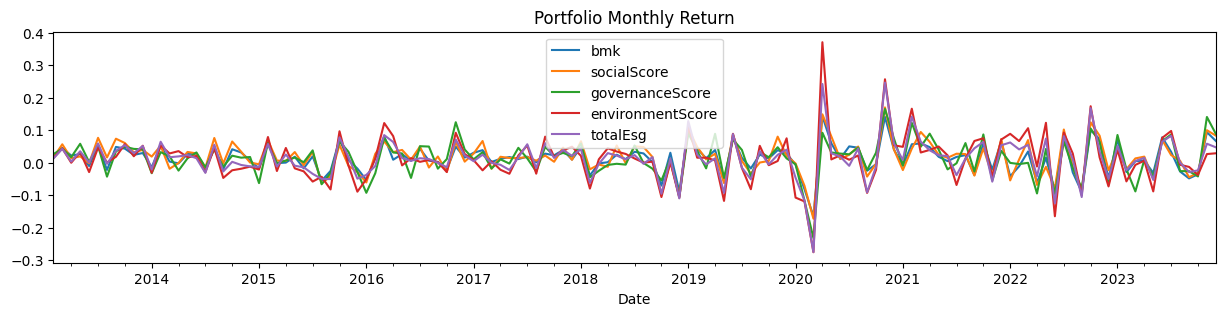

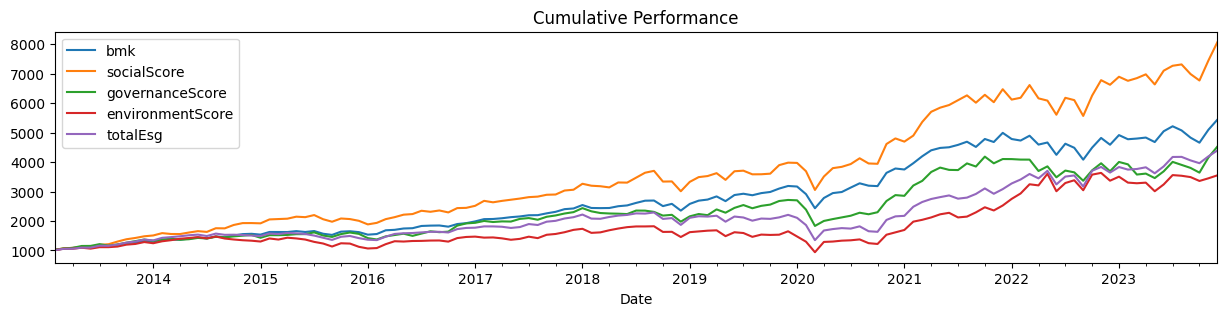

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
socialScore,0.210761,0.174513,-0.257697,4.377527,0.067446,0.096583,1.073413,-0.232665
bmk,0.167808,0.156738,-0.392643,4.716985,0.063448,0.092357,0.926011,-0.237178
governanceScore,0.148292,0.192251,-0.610413,5.306310,0.084426,0.117873,0.655186,-0.324747
totalEsg,0.145195,0.213512,-0.108498,8.350241,0.082985,0.131322,0.575664,-0.410337
environmentScore,0.123051,0.256073,0.566378,8.367654,0.088475,0.142464,0.394992,-0.483535


In [40]:
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 25

er_bmk = annualize_rets(returns_monthly, 12)
cov_bmk = returns_monthly.cov()

return_bmk = (ew(er_bmk) * returns_monthly).sum(axis=1)
wealth_bmk = drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data.sort_values(score, ascending=False).head(num_of_stocks).index

    er_port = annualize_rets(returns_monthly[stock_selected], 12)
    cov_port = returns_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * returns_monthly[stock_selected]).sum(axis=1)
    wealth_ = drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return', figsize=(15,3))
plt.show()

wealth_port.plot(title='Cumulative Performance', figsize=(15,3))
plt.show()

summary_stats(return_port, riskfree_rate=0.02, periods_per_year=12).sort_values('Sharpe Ratio', ascending=False)    

### Stock Selection 2
Assuming we selected the top 3 outperforming sectors correctly

<br>Sector = 'Commercial Services', 'Aerospace & Defense', 'Software & Services'
<br>Number of portfolios = 4
<br>Stock selection = Top 25 securities in each of social, governance, environment, total ESG ScorePortfolio Names:

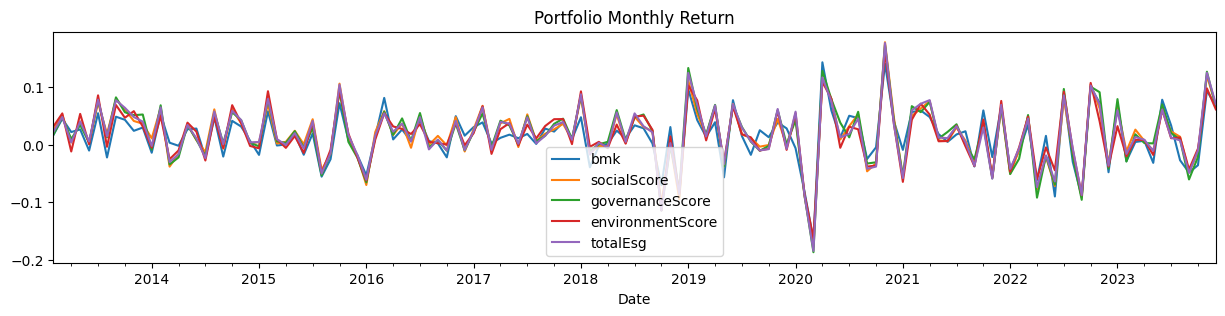

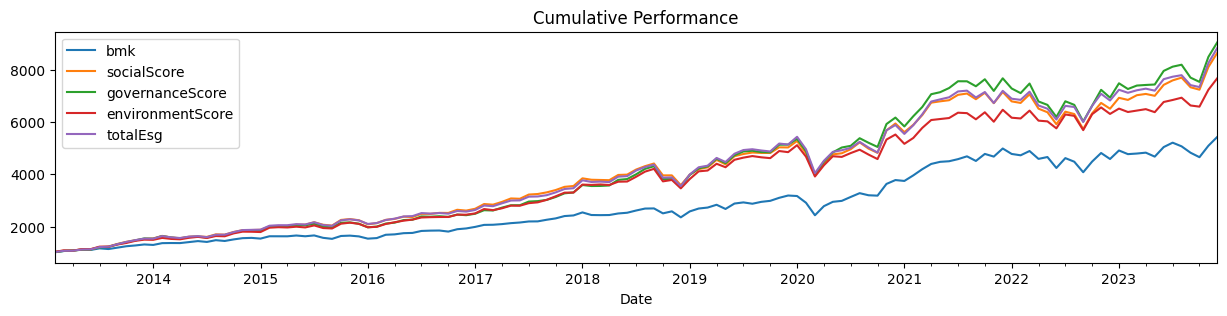

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
socialScore,0.218689,0.171644,-0.431416,4.766164,0.067473,0.100680,1.136729,-0.250130
totalEsg,0.221056,0.174296,-0.398674,4.840039,0.068074,0.099566,1.132764,-0.256052
governanceScore,0.223749,0.179568,-0.418648,4.629606,0.070911,0.103615,1.114229,-0.258053
environmentScore,0.205417,0.164997,-0.367945,4.376275,0.064755,0.094462,1.103528,-0.234312
bmk,0.167808,0.156738,-0.392643,4.716985,0.063448,0.092357,0.926011,-0.237178


In [50]:
sector_list = ['Commercial Services', 'Aerospace & Defense', 'Software & Services']
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 25

er_bmk = annualize_rets(returns_monthly, 12)
cov_bmk = returns_monthly.cov()

return_bmk = (ew(er_bmk) * returns_monthly).sum(axis=1)
wealth_bmk = drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data[full_data.peerGroup.isin(sector_list)].sort_values(score, ascending=False).head(num_of_stocks).index
    
    er_port = annualize_rets(returns_monthly[stock_selected], 12)
    cov_port = returns_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * returns_monthly[stock_selected]).sum(axis=1)
    wealth_ = drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return', figsize=(15,3))
plt.show()

wealth_port.plot(title='Cumulative Performance', figsize=(15,3))
plt.show()

summary_stats(return_port, riskfree_rate=0.02, periods_per_year=12).sort_values('Sharpe Ratio', ascending=False)      

### Stock Selection 3
Assuming we eliminated the top 3 underperforming sectors correctly

<br>Sector Excluded = 'Energy Servives', 'Industrial Conglomerates', 'Automobiles'
<br>Number of portfolios = 4
<br>Stock selection = Top 25 securities in each of social, governance, environment, total ESG ScorePortfolio Names:

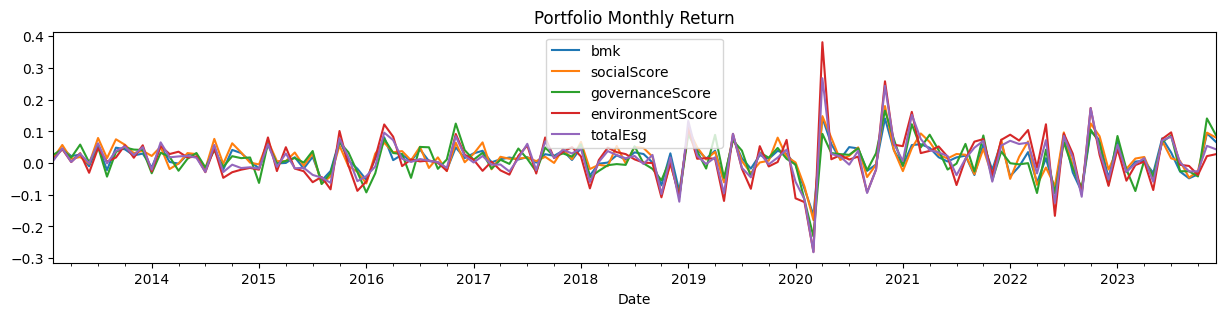

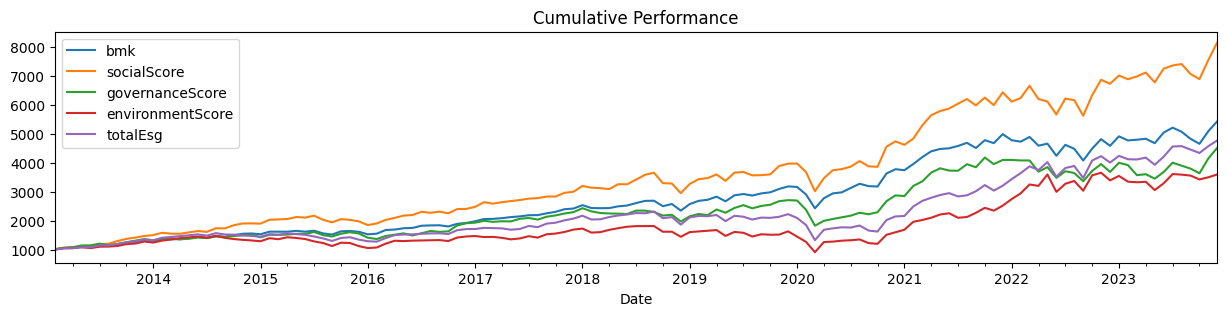

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
socialScore,0.212050,0.175299,-0.276658,4.715049,0.067643,0.097546,1.075826,-0.240616
bmk,0.167808,0.156738,-0.392643,4.716985,0.063448,0.092357,0.926011,-0.237178
governanceScore,0.148292,0.192251,-0.610413,5.306310,0.084426,0.117873,0.655186,-0.324747
totalEsg,0.154026,0.223435,-0.040772,8.065698,0.085780,0.134795,0.588897,-0.424445
environmentScore,0.124573,0.259186,0.583280,8.628770,0.088745,0.145236,0.396011,-0.495402


In [54]:
sector_list = [s for s in list(set(full_data.peerGroup)) if s not in ['Energy Servives','Industrial Conglomerates','Automobiles']]
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 25

er_bmk = annualize_rets(returns_monthly, 12)
cov_bmk = returns_monthly.cov()

return_bmk = (ew(er_bmk) * returns_monthly).sum(axis=1)
wealth_bmk = drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data[full_data.peerGroup.isin(sector_list)].sort_values(score, ascending=False).head(num_of_stocks).index
    
    er_port = annualize_rets(returns_monthly[stock_selected], 12)
    cov_port = returns_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * returns_monthly[stock_selected]).sum(axis=1)
    wealth_ = drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return', figsize=(15,3))
plt.show()

wealth_port.plot(title='Cumulative Performance', figsize=(15,3))
plt.show()

summary_stats(return_port, riskfree_rate=0.02, periods_per_year=12).sort_values('Sharpe Ratio', ascending=False)      

### Stock Selection 4
A native sector selection based on observation from the pairs plot. 
<br>Financials and Health Care have high governance and social score with average annualised returns and volatility.

<br>Sector = 'Diversified Financials', 'Healthcare'
<br>Number of portfolios = 4
<br>Stock selection = Top 25 securities in each of social, governance, environment, total ESG Score

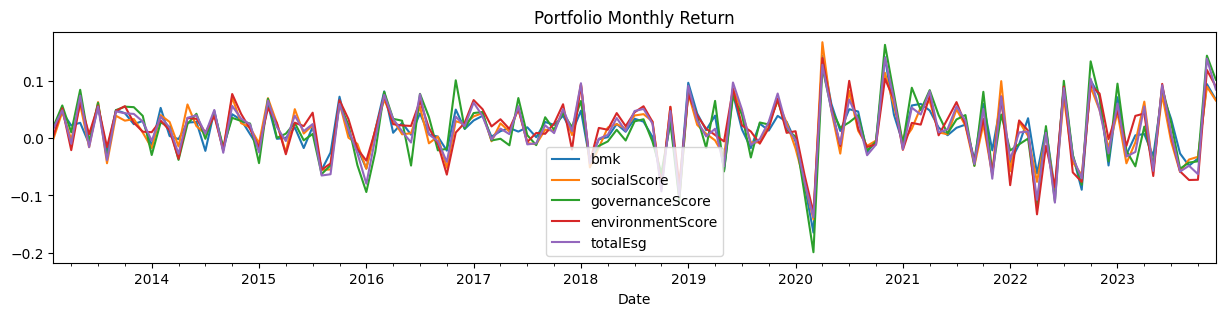

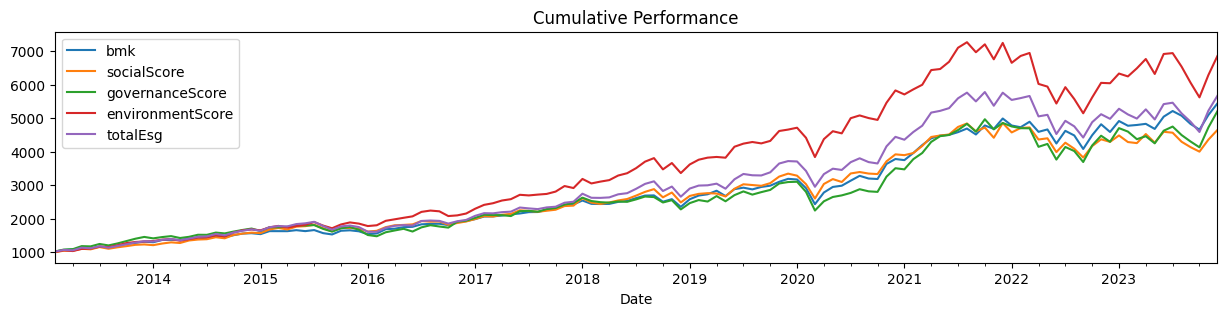

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
environmentScore,0.192809,0.172401,-0.488960,3.362673,0.071819,0.096654,0.984290,-0.291876
bmk,0.167808,0.156738,-0.392643,4.716985,0.063448,0.092357,0.926011,-0.237178
totalEsg,0.172216,0.178556,-0.321623,3.256816,0.074140,0.101243,0.837071,-0.235071
socialScore,0.151091,0.165903,-0.235095,3.653915,0.068053,0.092028,0.775874,-0.222235
governanceScore,0.163122,0.192930,-0.394343,4.137742,0.081821,0.115357,0.728381,-0.276879


In [59]:
sector_list = ['Diversified Financials', 'Healthcare']
score_list = ['socialScore','governanceScore','environmentScore','totalEsg']
num_of_stocks = 25

er_bmk = annualize_rets(returns_monthly, 12)
cov_bmk = returns_monthly.cov()

return_bmk = (ew(er_bmk) * returns_monthly).sum(axis=1)
wealth_bmk = drawdown(return_bmk).Wealth 

return_port = {}
wealth_port = {}

return_port['bmk'] = return_bmk
wealth_port['bmk'] = wealth_bmk

for score in score_list:
    return_ = {}
    wealth_ = {}
    
    stock_selected = full_data[full_data.peerGroup.isin(sector_list)].sort_values(score, ascending=False).head(num_of_stocks).index
    
    er_port = annualize_rets(returns_monthly[stock_selected], 12)
    cov_port = returns_monthly[stock_selected].cov()
    
    return_ = (ew(er_port) * returns_monthly[stock_selected]).sum(axis=1)
    wealth_ = drawdown(return_).Wealth 

    return_port[score] = return_
    wealth_port[score] = wealth_
    
return_port = pd.DataFrame(return_port)
wealth_port = pd.DataFrame(wealth_port)    

return_port.plot(title='Portfolio Monthly Return', figsize=(15,3))
plt.show()

wealth_port.plot(title='Cumulative Performance', figsize=(15,3))
plt.show()

summary_stats(return_port, riskfree_rate=0.02, periods_per_year=12).sort_values('Sharpe Ratio', ascending=False)      